# load DAS data and make some plots

In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from xhistogram.xarray import histogram
#import dashydro.hydro as hy

---

## load data

In [2]:
root_data_dir = "/Users/aponte/Cloud/Dropbox/Public/das"
zarr = os.path.join(root_data_dir, "das/DAST_Toulon_July2019_strain.zarr")

In [3]:
ds = xr.open_zarr(zarr)
ds

<xarray.Dataset>
Dimensions:  (channel: 4480, time: 12708)
Coordinates:
  * channel  (channel) int64 1 2 3 4 5 6 7 ... 4475 4476 4477 4478 4479 4480
    depth    (channel) float64 dask.array<chunksize=(4480,), meta=np.ndarray>
    lat      (channel) float64 dask.array<chunksize=(4480,), meta=np.ndarray>
    lon      (channel) float64 dask.array<chunksize=(4480,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2019-07-13T16:37:52 ... 2019-07-31T08:17:56
Data variables:
    strain   (channel, time) float64 dask.array<chunksize=(1120, 12708), meta=np.ndarray>

In [4]:
dt = float((ds.time[1]-ds.time[0])/pd.Timedelta("1T"))
print(f"Time sampling : dt = {dt} min")

Time sampling : dt = 2.0 min


---

## global perspective

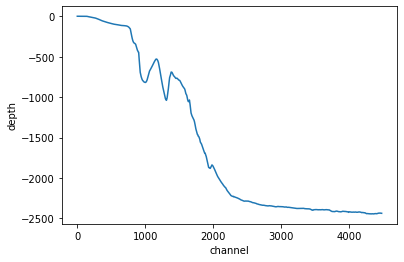

In [5]:
(-ds.depth).plot()

### raw data

There are extremely large peaks (4 orders of magnitude larger than elsewhere) around channel 200.

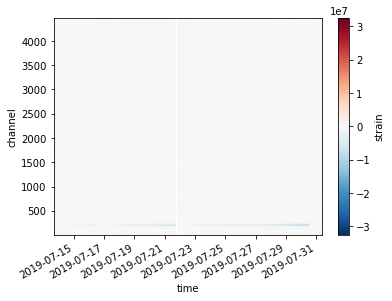

In [6]:
_da = ds.strain.isel(time=slice(0,None,15))
_da.plot()
#np.log10(_da).plot(figsize=(10,10))

### DAS data is divided into three distinct time periods:

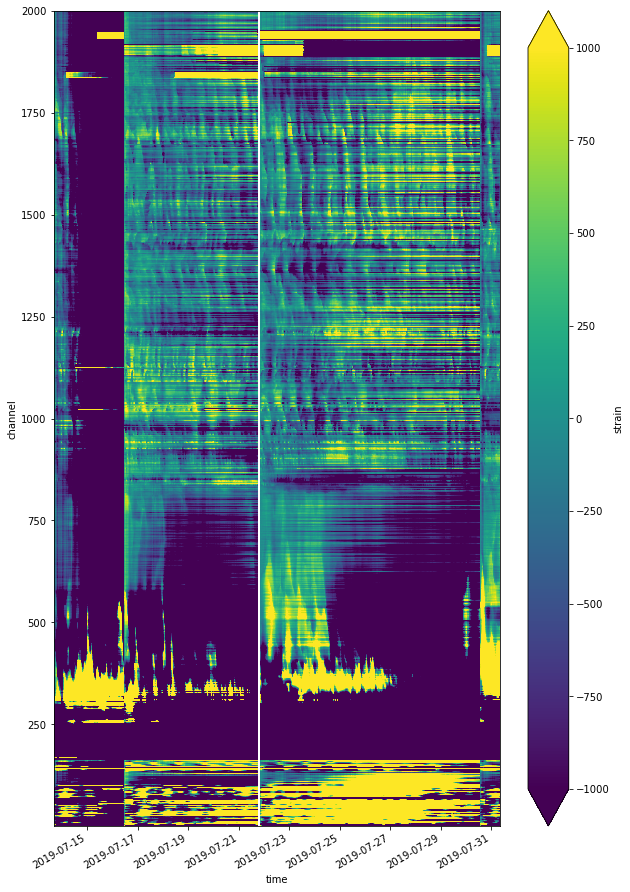

In [19]:
# time slice used for plotting, will be used throughout the notebook
tslice = slice(0,None,15)

_da = ds.strain.isel(time=tslice)
_da.plot(vmin=-1e3, vmax=1e3, figsize=(10,15))
#np.log10(_da).plot(figsize=(10,10))

### data above channel 2000 does not seem to contain any signal, it is ignored from now on

In [9]:
ds = ds.sel(channel=slice(0,2000))

### Substracting the median strain value across channels at any instant in time corrects for the large offset in the first time period:

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


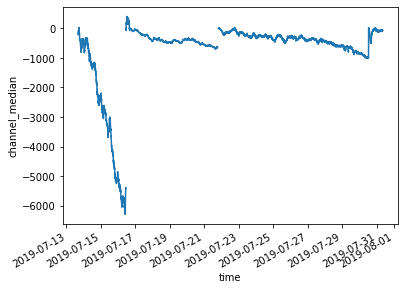

In [10]:
ds["channel_median"] = ds.strain.median("channel")
ds["channel_median"].plot()

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


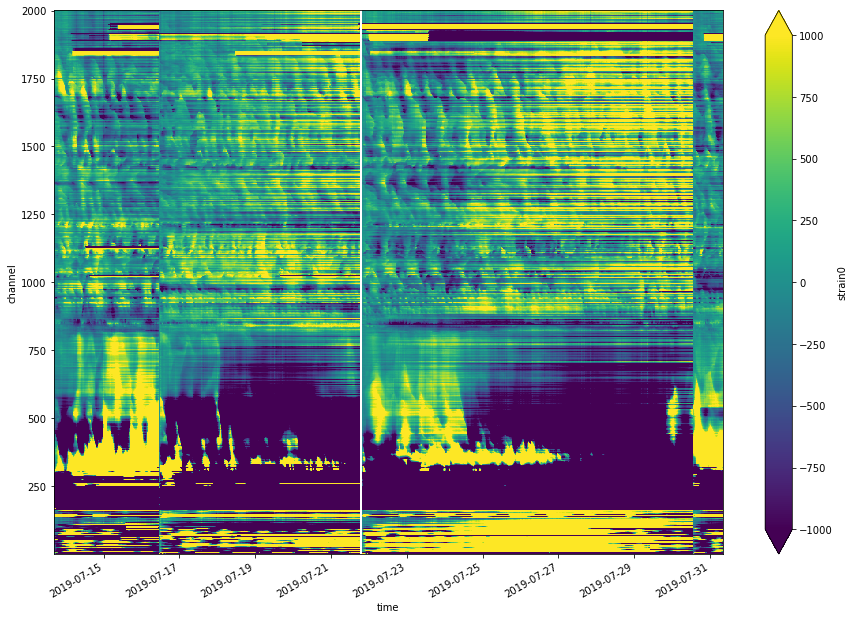

In [18]:
ds["strain0"] = (ds.strain - ds.channel_median)
_da = ds.strain0.isel(time=tslice)
vmin, vmax= -1e3, 1e3
#vmin, vmax = None, None
_da.plot(vmin=vmin, vmax=vmax, figsize=(15,10))

# to smooth jumps between time period further, we differentiate in time, set à 0 extreme time variations and integrate back

In [20]:
# removes and fill steps
_da = ds.strain0.fillna(0.).diff("time")
_da = _da.where(np.abs(_da)<200, other=0).cumsum("time")
ds["strain1"] = _da

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


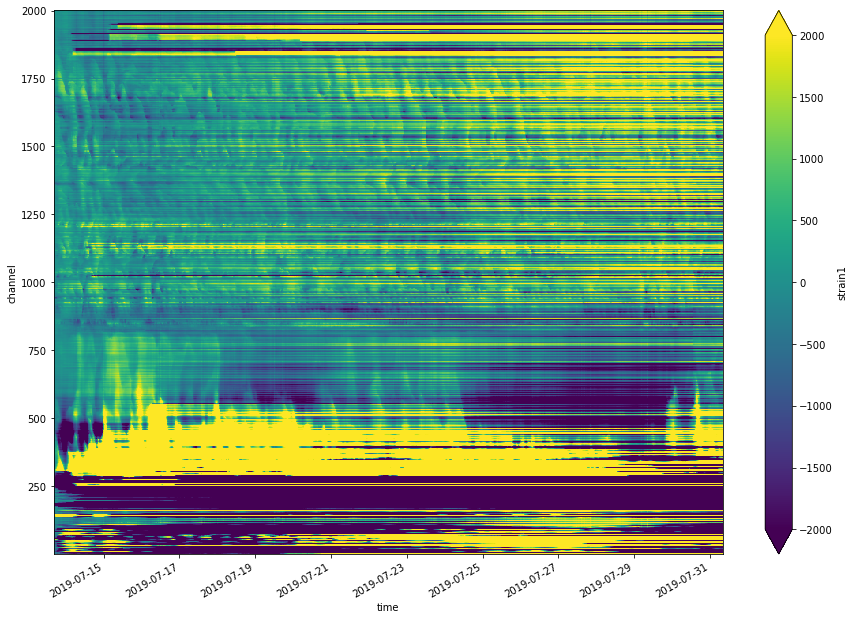

In [26]:
vmin, vmax= -2e3, 2e3
#vmin, vmax = None, None

ds.strain1.isel(time=tslice).plot(vmin=vmin, vmax=vmax, figsize=(15,10))

### focus on across channel variations: detrend, averaging in channel direction

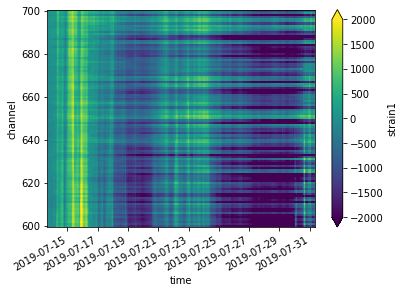

In [99]:
vmin, vmax= -2e3, 2e3
#vmin, vmax = None, None

ds.strain1.isel(time=tslice).sel(channel=slice(600,700)).plot(vmin=vmin, vmax=vmax)

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


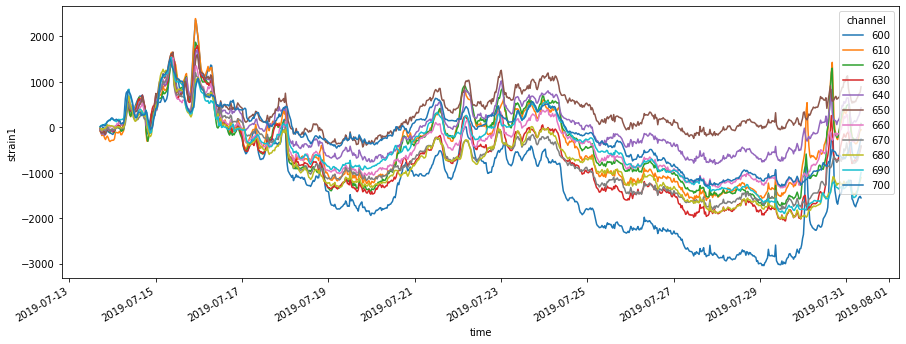

In [29]:
vmin, vmax= -2e3, 2e3
#vmin, vmax = None, None

ds.strain1.isel(time=tslice).sel(channel=slice(600,700,10)).plot.line(x="time", figsize=(15,5))

### detrend data

In [34]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


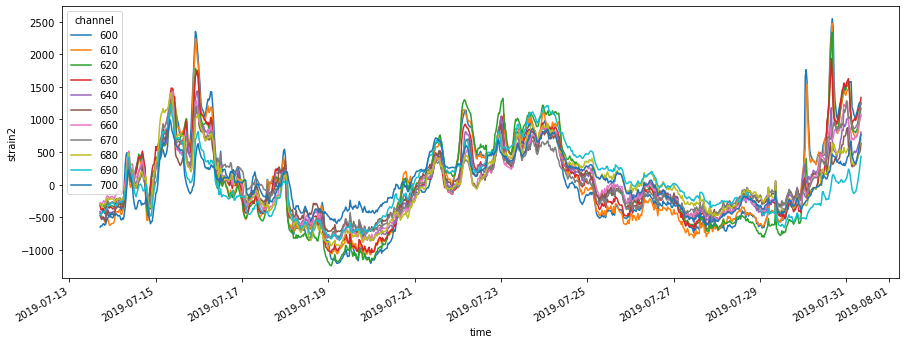

In [37]:
ds["strain2"] = detrend_dim(ds.strain1, "time", deg=1)

(ds.strain2
 .isel(time=tslice)
 .sel(channel=slice(600,700,10))
 .plot.line(x="time", figsize=(15,5))
);

### there is clear noise at the channel interval, we can average it out by resampling data

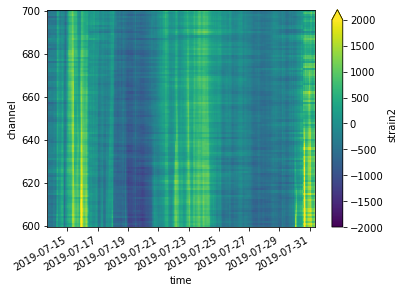

In [98]:
vmin, vmax= -2e3, 2e3
#vmin, vmax = None, None

ds.strain2.isel(time=tslice).sel(channel=slice(600,700)).plot(vmin=vmin, vmax=vmax)

We average 5 channels (approx. 50m) together at any instant in time.

Keep this in mind for the loss of spatial/temporal resolution that this choice induces

This may not be necessary depending on the target analysis.

In [85]:
dsc = ds.strain2.coarsen(channel=5, boundary="trim").mean().rename("strain3").to_dataset()

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


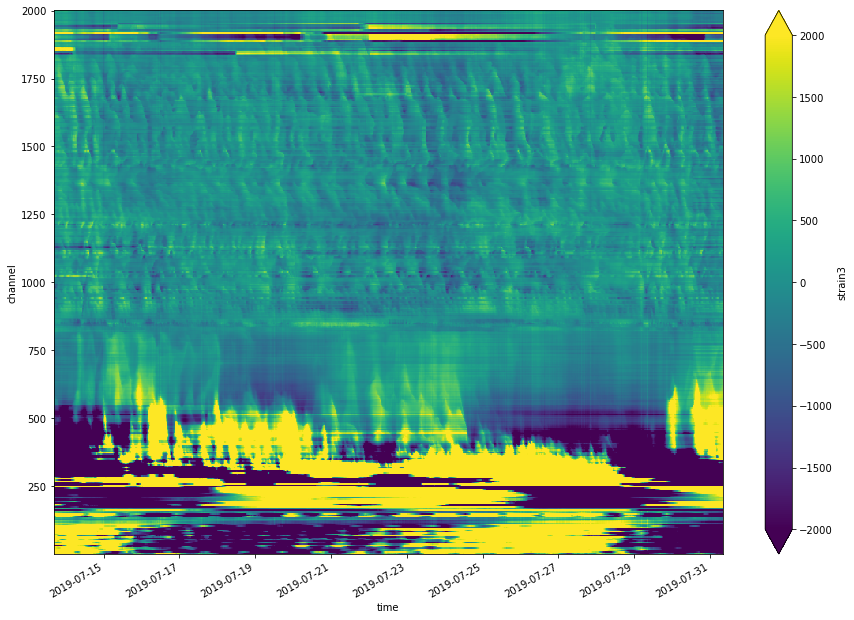

In [95]:
vmin, vmax= -2e3, 2e3
#vmin, vmax = None, None

dsc.strain3.isel(time=tslice).plot(vmin=vmin, vmax=vmax, figsize=(15,10))

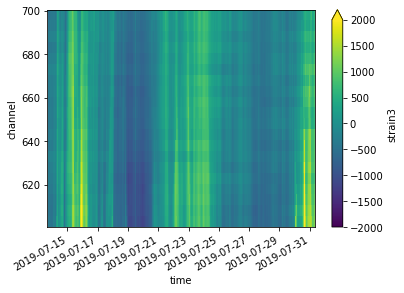

In [96]:
vmin, vmax= -2e3, 2e3
#vmin, vmax = None, None

dsc.strain3.isel(time=tslice).sel(channel=slice(600,700)).plot(vmin=vmin, vmax=vmax)

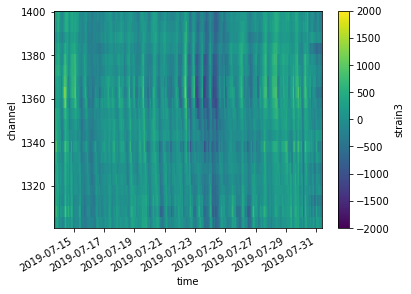

In [97]:
vmin, vmax= -2e3, 2e3
#vmin, vmax = None, None

dsc.strain3.isel(time=tslice).sel(channel=slice(1300,1400)).plot(vmin=vmin, vmax=vmax)

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


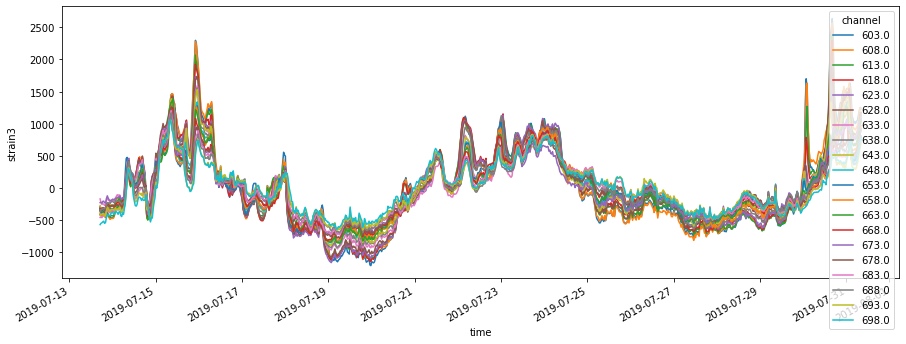

In [93]:
(dsc.strain3
 .isel(time=tslice)
 .sel(channel=slice(600,700))
 .plot.line(x="time", figsize=(15,5))
);

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


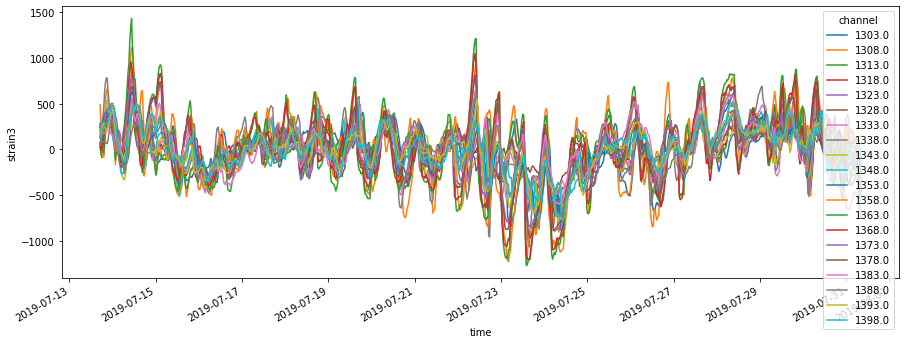

In [94]:
(dsc.strain3
 .isel(time=tslice)
 .sel(channel=slice(1300,1400))
 .plot.line(x="time", figsize=(15,5))
);

### histogram of strain values

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


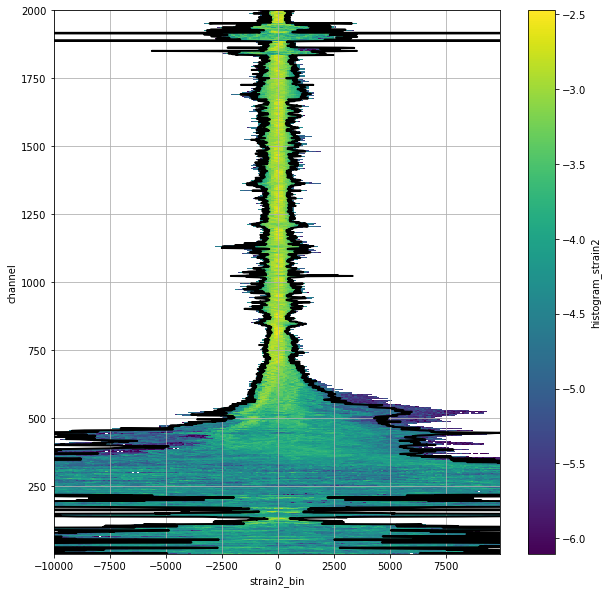

In [100]:
h_strain2 = histogram(ds.strain2, dim=["time"], bins=np.arange(-10000,10000,100), density=True)
q = ds.strain2.chunk(dict(time=-1)).quantile([.01, .99], "time").compute()

fig, ax = plt.subplots(1,1, figsize=(10,10))
np.log10(h_strain2).plot()
ax.plot(q.isel(quantile=0), q.channel, "k", lw=2)
ax.plot(q.isel(quantile=1), q.channel, "k", lw=2)
#dstrain_dt.median("time").plot(y="channel", color="k")
ax.grid()

---
### compute and show autocorrelations and spectra

Could use variograms instead of autocorrelations


These could be used to:

- detect variations of coupling conditions
- compare with canonical spectral distributions of internal wave variability

In [101]:
import sstats.sigp as sigp

def autocorrelation(x):    
    da = x - x.mean()
    da = da.fillna(0)
    da = da.assign_coords(time=(da.time - da.time[0])/pd.Timedelta("1H"))
    c = sigp.correlate(da, da).compute()
    return c

In [103]:
C = autocorrelation(ds.strain2).rename("C")

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


In [109]:
lag_slice = slice(0,None, 10)

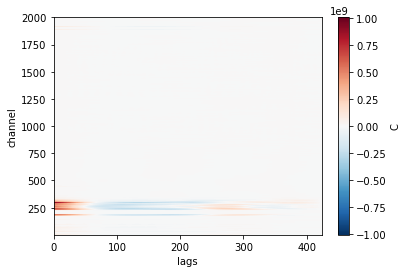

In [110]:
C.isel(lags=lag_slice).plot(x="lags")

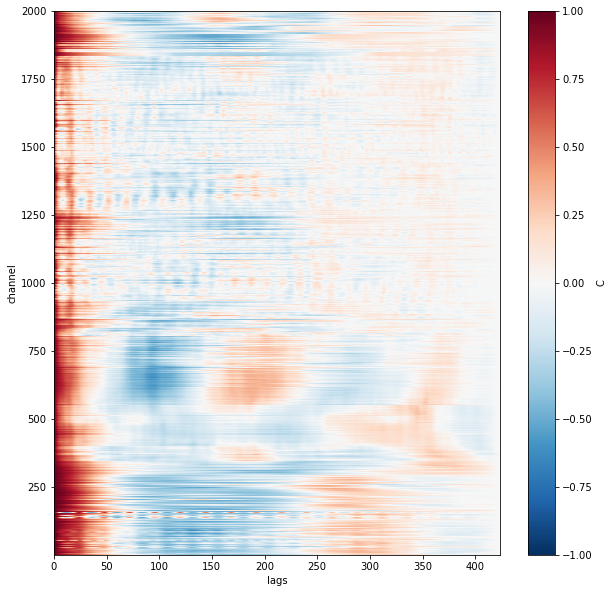

In [113]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
_C = (C.isel(lags=lag_slice)/C.sel(lags=0))
_C.plot(x="lags")

In [135]:
import sstats.sigp as sigp

def spectra(x, T):    
    da = x - x.mean()
    da = da.fillna(0)
    da = da.assign_coords(time=(da.time - da.time[0])/pd.Timedelta("1D"))
    E, f = sigp.spectrum_welch(da, T=T, return_onesided=True)
    return E

In [136]:
E = spectra(ds.strain2, 4).rename("E")

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


In [137]:
_da = ds.strain_nostep.resample(time="2D").mean()
ds["strain_low"] = _da.interp(time=ds.time)

AttributeError: 'Dataset' object has no attribute 'strain_nostep'

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


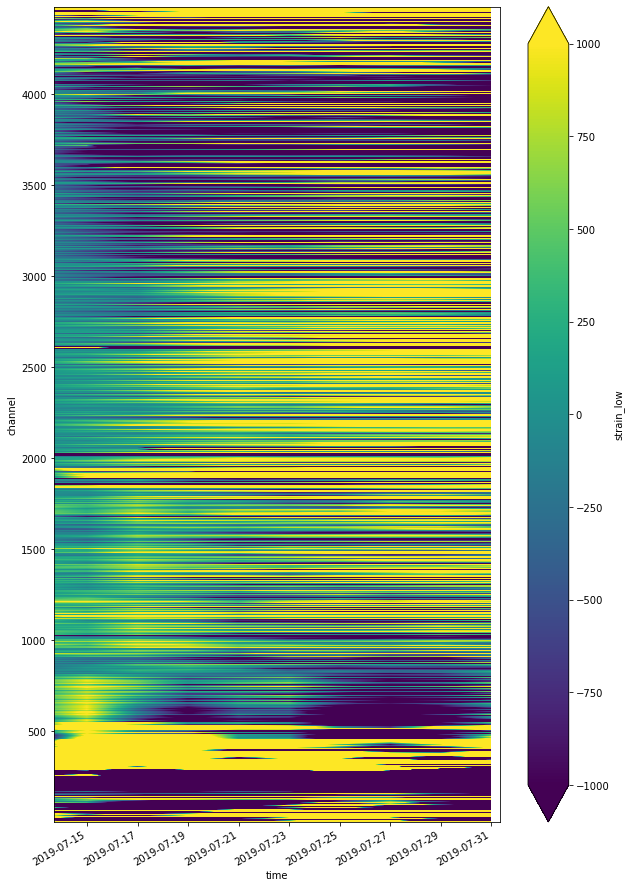

In [13]:
_da = ds.strain_low
_da.isel(time=slice(0,None,15)).plot(vmin=-1e3, vmax=1e3, figsize=(10,15))

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


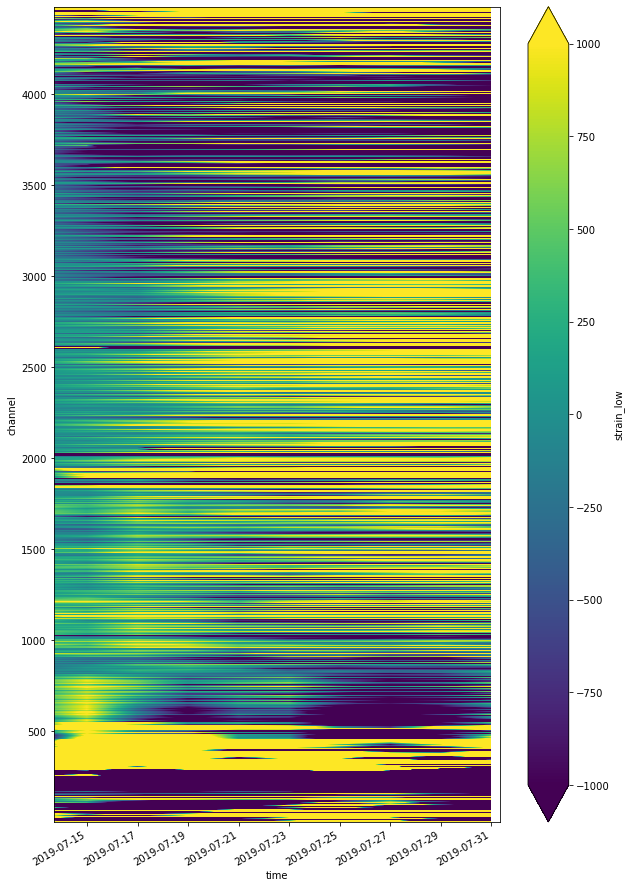

In [14]:
ds["strain_clean"] = ds.strain_nostep - ds.strain_low
_da.isel(time=slice(0,None,15)).plot(vmin=-1e3, vmax=1e3, figsize=(10,15))

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


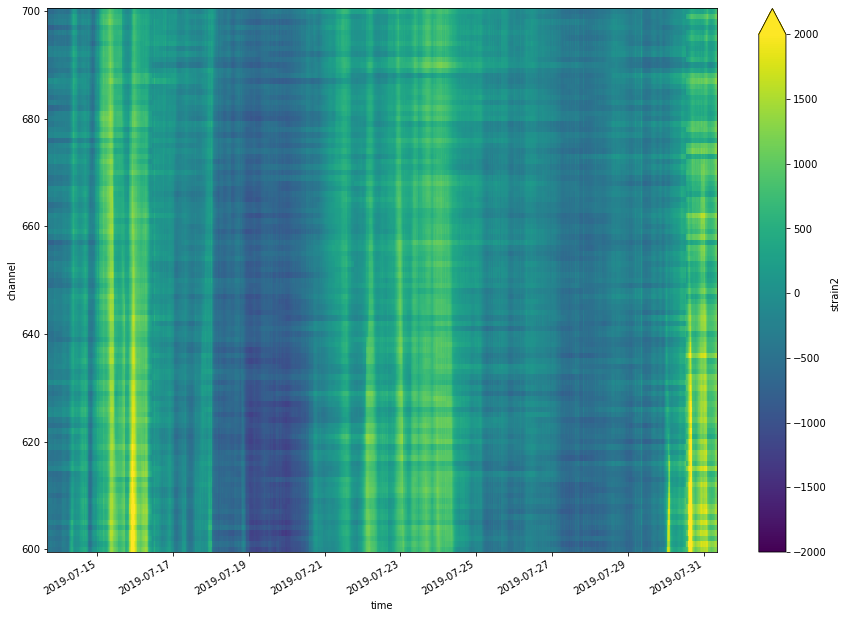

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


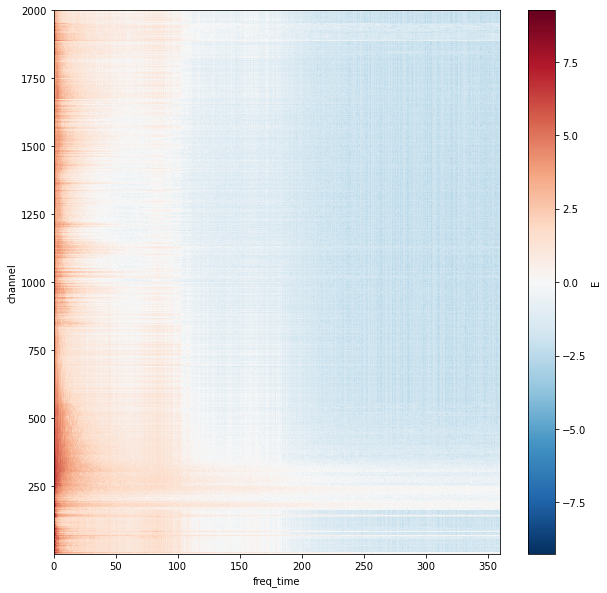

In [138]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
np.log10(E).plot(x="freq_time")

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


Text(0.5, 0, 'frequency [cycles per days]')

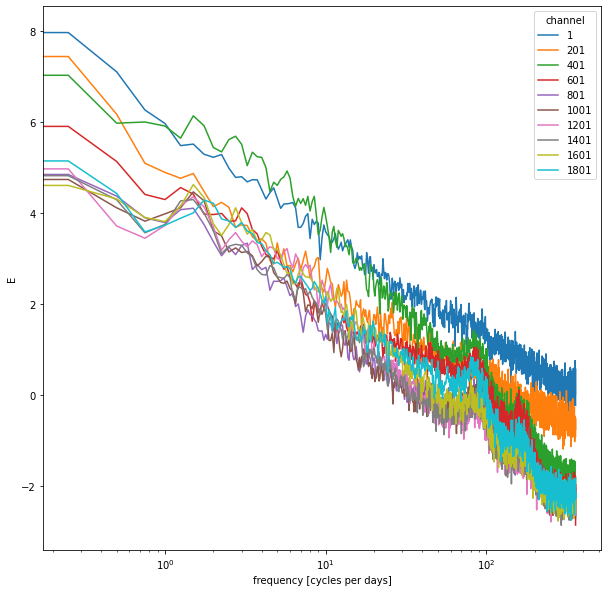

In [141]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

_E = E.sel(channel=slice(0,None,200))
np.log10(_E).plot.line(x="freq_time", xscale="log");

ax.set_xlabel("frequency [cycles per days]")

--- 

## Histogram of time rate of change and channel rate of change

In [15]:
dstrain_dt = ds.strain.diff("time").rename("d(strain)/dt")
dstrain_dc = ds.strain.diff("channel").rename("d(strain)/dc")
h_t = histogram(dstrain_dt, dim=["time"], bins=np.arange(-100,100,1), density=True)
h_c = histogram(dstrain_dc, dim=["channel"], bins=np.arange(-1000,1000,10), density=True)

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


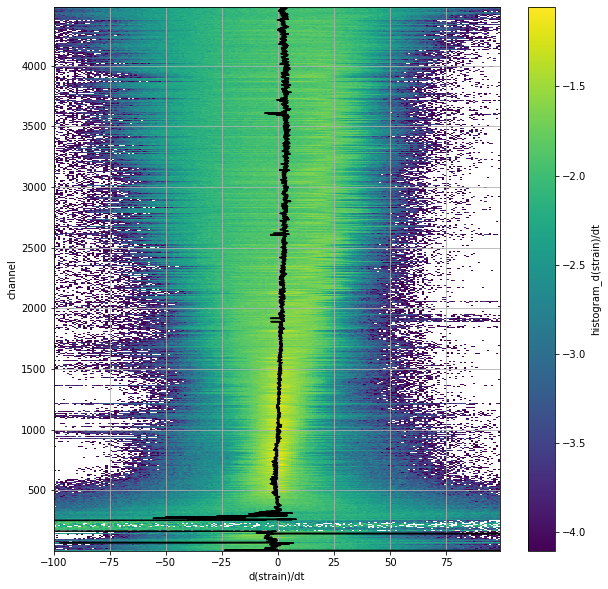

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
np.log10(h_t).plot()
dstrain_dt.median("time").plot(y="channel", color="k")
ax.grid()

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


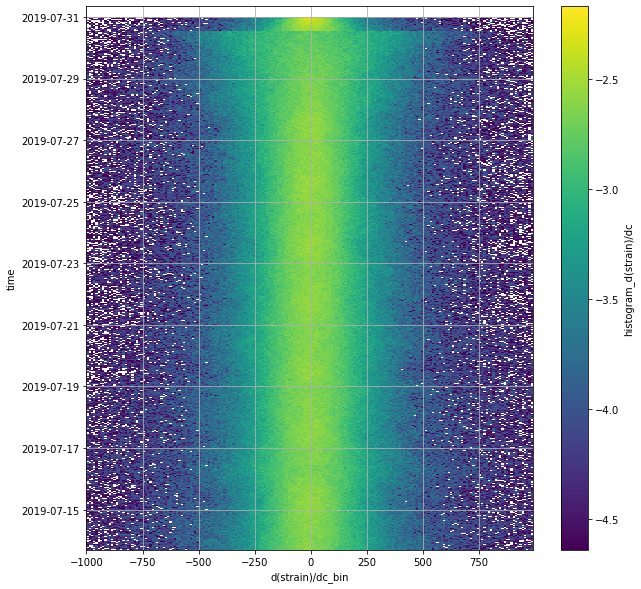

In [17]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
np.log10(h_c).plot()
#dstrain_dt.median("time").plot(y="channel", color="k")
ax.grid()

---
## adressing scale distortion

In [20]:
ds = ds.assign_coords(s=np.abs(ds.depth.diff("channel")).cumsum("channel"))

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


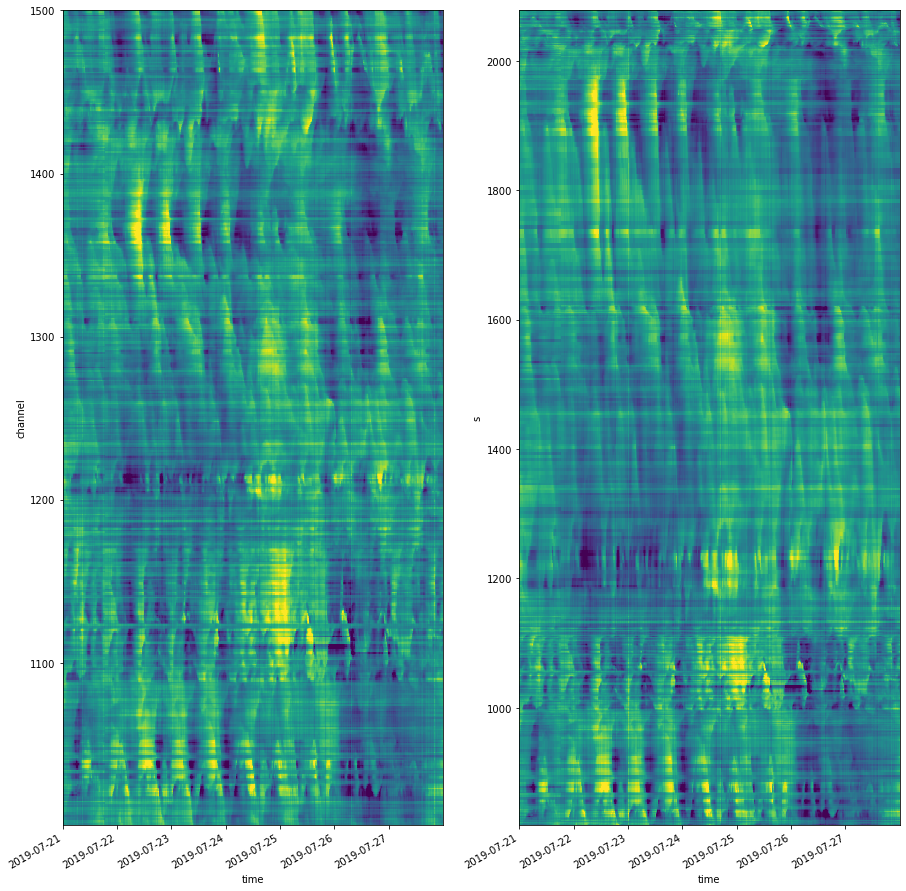

In [21]:
_da = ds.strain2.isel(channel=slice(1000,1900))
_da = _da.sel(time=slice("2019/07/21","2019/07/27"))

fig, axes = plt.subplots(1,2, figsize=(15,15))
_da.plot(ax=axes[0], vmin=-1e3, vmax=1e3, add_colorbar=False)
_da.plot(ax=axes[1], y="s", vmin=-1e3, vmax=1e3, add_colorbar=False)

On the plots above, you can directly interpret the length scales on the right as "apparent length scales" while this is not the case for the figure on the left.